In [23]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler


#### Step 2: Loading the Dataset

<AxesSubplot:>

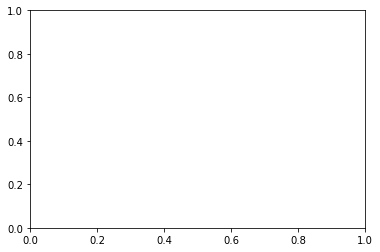

In [20]:
# Transforms images to a PyTorch Tensor
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))]) #NOTE: change the range of the data from 0 to 1 TO -1 to 1.
  
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data", # The location of the downlode file
    train=True,
    download=True,
    transform=transform,
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(dataset = training_data, 
                              batch_size = batch_size,
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_data, 
                             batch_size=batch_size,
                             shuffle = True)
plt.subplot()

In [22]:
print(type(train_dataloader.dataset))
for X, y in test_dataloader:
    print(f"Shape of X [Batch size, Channel, Height, Width]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f'The maximum value is {torch.max(X)} and minimum value is {torch.min(X)}')
    break

<class 'torchvision.datasets.mnist.MNIST'>
Shape of X [Batch size, Channel, Height, Width]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
The maximum value is 1.0 and minimum value is -1.0


### Create Autoencoder Class

In [9]:
# Creating a PyTorch class
class AE_dense(torch.nn.Module):
    def __init__(self):
        super(AE_dense,self).__init__()
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 400 ==> 100
        self.encoder = torch.nn.Sequential(

            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )
          
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 100 ==> 400
        self.decoder = torch.nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded,  
    #! NOTE! when calling model(data), it returns a tuple (decoded, encoded). 
    #! Or you can just choose the first value for training.

In [42]:
# Creating a PyTorch class
class AE_conv(torch.nn.Module):
    def __init__(self):
        super(AE_conv,self).__init__()
        # Building a convolution encoder with convolutional
        # layer followed by Relu activation function
        # 400 ==> 100
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride = 1, padding=1), # 28 * 28 -> 14 * 14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            
            # nn.Conv2d(16, 32, 3, stride=2,padding=1) #14 * 14 -> 7 * 7
            # nn.ReLU()
            # nn.Conv2d(32, 32, 3, padding=1)
            # nn.ReLU()
            # nn.Flatten() # Image grid to single feature vector
            # nn.Linear(2*16*c_hid, latent_dim)

        )
          
        # Building an convolution decoder with convolutional
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 100 ==> 400
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16,6,3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(6,3,3, padding=1),
            nn.ReLU())   
        
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded,  
    #! NOTE! when calling model(data), it returns a tuple (decoded, encoded). 
    #! Or you can just choose the first value for training.

### Initializing models

In [49]:
from torchsummary import summary
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Model Initialization
model = AE_conv().to(device)
  
# Validation using MSE Loss function
loss_fn = torch.nn.MSELoss()
  
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-2,
                             weight_decay = 1e-8)
summary(model, (1, 28, 28))


Using cpu device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]             880
              ReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
   ConvTranspose2d-7              [-1, 6, 7, 7]             870
              ReLU-8              [-1, 6, 7, 7]               0
   ConvTranspose2d-9              [-1, 3, 7, 7]             165
             ReLU-10              [-1, 3, 7, 7]               0
Total params: 1,975
Trainable params: 1,975
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.0

### Define training function 

In [44]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # return the number of training samples
    model.train() #Tell the model you are going to train so the weights will be updated
    for batch, (X, y) in enumerate(dataloader): # iterates the dataloader 
        # X = X.view(X.size(0),-1)
        
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X) #! NOTE: Here the returned value is a tuple (decoded, encoded) as defined in forward()
        loss = loss_fn(pred[0], X) # Choose the first value pred[0] as decoded value for the purpose of training
                                    #! NOTE: the second argument should be the original value
        # Backpropagation
        optimizer.zero_grad() # to reset the gradients of model parameters.
        loss.backward() # PyTorch deposits the gradients of the loss w.r.t. each parameter.
        optimizer.step() # to adjust the parameters by the gradients collected in the backward pass.

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [45]:
def show(dataloader, model, num):
    '''Plot the original and reconstructed images together

    Args:
        dataloader (data_loader): an object that wraps the dataset
        model (model): autoencoder
        num (int): the number of samples to be plotted
    '''
    model.eval() #Tell the model you are going to test so the weights will not be updated
    with torch.no_grad():
        for i, (X, y) in enumerate(dataloader):
            # X = X.view(X.size(0), -1)
            X, y = X.to(device), y.to(device) # to is one of the operations(methods) in tensor object
            
            pred = model(X)
            reconstructed = pred[0].reshape(-1,28,28)
            print(reconstructed.shape)
            X = X.reshape(-1,28,28)
            print(X.shape)
            
            # plot part
            fig, axs = plt.subplots(2,num, figsize=(20,5)) # 2 means two rows
            for j in range(num):
                # display the original image
                axs[0][j].imshow(X[j]) ##Note axs is a matrix, you can't just wirte axs[], it should be axs[][]
                # display the reconstructed image
                axs[1][j].imshow(reconstructed[j])
            break

###  Start training and validating

In [46]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    # test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


/Users/button/.conda/envs/py3_8/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64, 1, 28, 28])) that is different to the input size (torch.Size([64, 3, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (7) must match the size of tensor b (28) at non-singleton dimension 3

###  Input/Reconstructed Input to/from Autoencoder

torch.Size([64, 28, 28])
torch.Size([64, 28, 28])


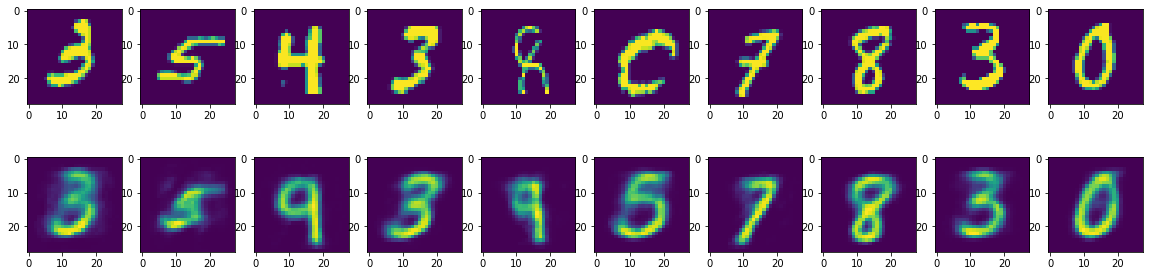

In [270]:
show(test_dataloader,model,10)